In [1]:
#Import libraries:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import gc

from sklearn.svm import  OneClassSVM
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

sns.set_style('whitegrid')

In [2]:
import os
print(os.listdir("../Elo-Merchant-Category-Recommendation/"))

['Data_Dictionary.xlsx', 'test.csv', 'historical_transactions.csv', 'Elo-Merchant-Category-Recommendation.zip', 'new_merchant_transactions.csv', '.ipynb_checkpoints', 'sample_submission.csv', '.git', '.gitignore', 'LICENSE', 'train.csv', 'basic_model.py.ipynb', 'README.md', 'merchants.csv']


In [5]:
train_df = pd.read_csv('../Elo-Merchant-Category-Recommendation/train.csv')
test_df = pd.read_csv('../Elo-Merchant-Category-Recommendation/test.csv')
#df_hist_trans = pd.read_csv('../Elo-Merchant-Category-Recommendation/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('../Elo-Merchant-Category-Recommendation/new_merchant_transactions.csv')

## Basic model to test extent before advanced models

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


no missing data

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null object
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.7+ MB


1 data point missing

filling NAs

In [11]:
test_df['first_active_month'] = test_df['first_active_month'].fillna('2018-01-01')

In [12]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


#### partition of features

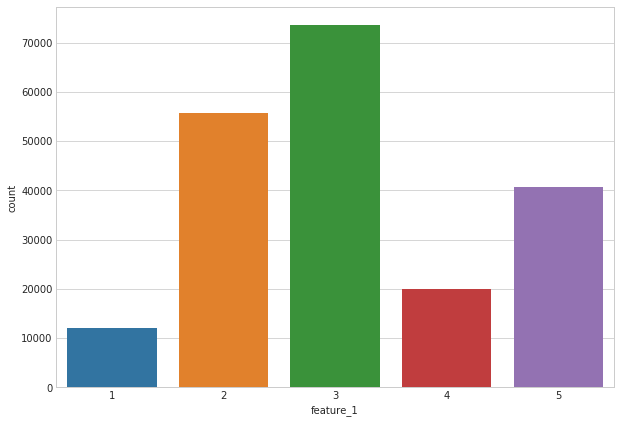

In [13]:
plt.figure(figsize=(10, 7))
sns.countplot(train_df['feature_1'])
plt.show()

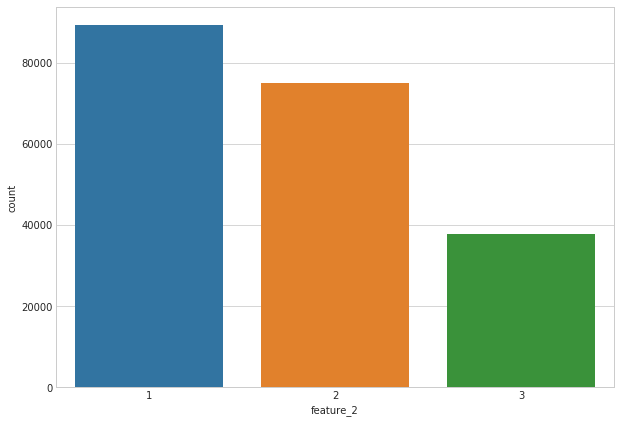

In [14]:
plt.figure(figsize=(10, 7))
sns.countplot(train_df['feature_2'])
plt.show()

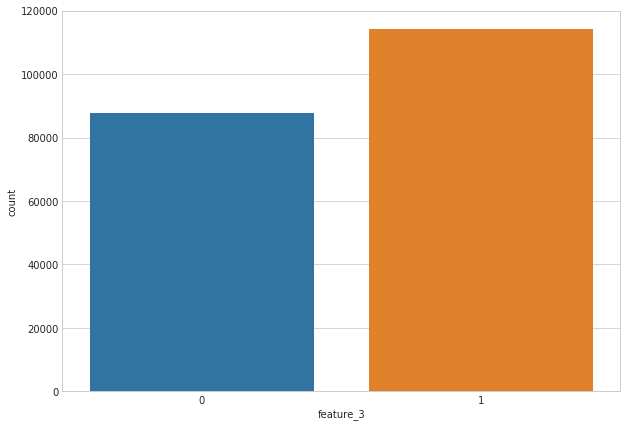

In [16]:
plt.figure(figsize=(10, 7))
sns.countplot(train_df['feature_3'])
plt.show()

Features seem pretty balanced.

#### First active month